In [2]:
# Imports
import os

# import methods from FIA python script
from FIA import *

oms.LogConfigHandler().setLogLevel("DEBUG")

## Loading

In [3]:
# set path to your mzML files and workfolder
data_dir = "../../data/example data/exampleA_ecolistrains"
run_dir = "../../runs/fia_explorer"

data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# clean_dir(run_dir)

In [4]:
fia_df = load_fia_df(data_dir, ".mzXML")

Loading experiments:
Loading names:


## Initial Centroiding

#### TOF Parameters


In [5]:
fia_df["cent_experiment"] = fia_df["experiment"].apply(lambda experiment: centroid_experiment(experiment, instrument="TOF",
                                                                                                signal_to_noise=2.0, spacing_difference=1.5,
                                                                                                peak_width=0.0, sn_bin_count=100, nr_iterations=5, sn_win_len=20.0,
                                                                                                check_width_internally="false", ms1_only="true", clear_meta_data="false",
                                                                                                deepcopy=False))

## Data pruning & binning

In [6]:
# Computes mean, media or sum of binned peaks (median needs ~2* more time)
fia_df["bin_experiment"] = fia_df["experiment"].apply(lambda experiment: limit_experiment(experiment, 51, 1699, 2*10**6, statistic="sum", deepcopy=True))

## Summing intensities

In [7]:
fia_df["sum_spectra"] = fia_df["bin_experiment"].apply(lambda experiment: sum_spectra(experiment)) # type: ignore

## Combining

In [8]:
comb_df = pd.DataFrame(columns=["polarity", "comb_experiment"])
for polarity in fia_df["polarity"].unique():
    comb_df.loc[len(comb_df.index)] = [polarity, combine_spectra_experiments(fia_df.loc[fia_df["polarity"] == polarity]["sum_spectra"].to_list())]

## Clustering

In [9]:
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster, linkage

### Clustering

In [10]:
def extract_from_clustering(df, clustering):
    """
    accumarray(clusters, (peak_selection(:,1)) .* (peak_selection(:,2)).^5) ./ accumarray(clusters, peak_selection(:,2).^5);
    accumarray(clusters, peak_selection(:,2),[],@max);   
    """
    mzs = []
    intys = []
    for c in np.unique(clustering):
        indices = clustering == c
        intys_clust = df["inty"][indices].values
        mzs_clust = df["mz"][indices].values
        inty = np.max(intys_clust)
        mz = np.sum(mzs_clust * intys_clust**3) / np.sum(intys_clust**3)
        mzs.append(mz)
        intys.append(inty)

    # Packaging
    clustered_spectrum = oms.MSSpectrum()
    clustered_experiment = oms.MSExperiment()
    clustered_spectrum.set_peaks( [mzs, intys] )        # type: ignore
    clustered_experiment.addSpectrum(clustered_spectrum)
    return clustered_experiment

def cluster_matlab(comb_experiment:oms.MSExperiment, height_lim:int=1000, prominence_lim:int=1000, lower_lim:int=8000, upper_lim:int=12000, threshold:float=7e-2 **2):
    """
    Clusters according to FIA matlab routine
    """
    # Extract Dataframe
    clust_df = comb_experiment.get_df(long=True)
    clust_df = clust_df.sort_values("mz", ignore_index=True)

    # Peak detection
    peaks, *_ = find_peaks(clust_df["inty"], height=height_lim, prominence=prominence_lim)
    peaked_df = clust_df.loc[peaks].reset_index(drop=True)

    # Distance calculation @(x,y) (x(:,1)-y(:,1)).^2  + (x(:,2)==y(:,2))*10^6; 
    distances = pdist(peaked_df["mz"].values[lower_lim:upper_lim].reshape(-1,1), metric="cityblock")**2 +\
                pdist(peaked_df["RT"].values[lower_lim:upper_lim].reshape(-1,1), metric="hamming")*1e6
    tree = linkage(distances, method="complete")
    clustering =  fcluster(tree, t=threshold, criterion="distance")
    return extract_from_clustering(peaked_df.loc[lower_lim:upper_lim-1], clustering)

In [11]:
comb_df["clustered_experiment"] = comb_df["comb_experiment"].apply(lambda experiment: cluster_matlab(experiment,
                                                                                                     height_lim=1000, prominence_lim=1000,
                                                                                                     lower_lim=8000, upper_lim=12000, threshold=7e-2 **2) )

In [12]:
comb_df

,polarity,comb_experiment,clustered_experiment
0,-1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._dataframes._MSExperimentDF object a...
1,1,<pyopenms._dataframes._MSExperimentDF object a...,<pyopenms._dataframes._MSExperimentDF object a...


## Merging

## Plotting

c:\Users\JosuaCarl\Desktop\Thesis\MStoML\skripts\FIA\FIA.py:1361: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, hue=hue, size=size, sizes=sizes, palette=palette)  # type: ignore


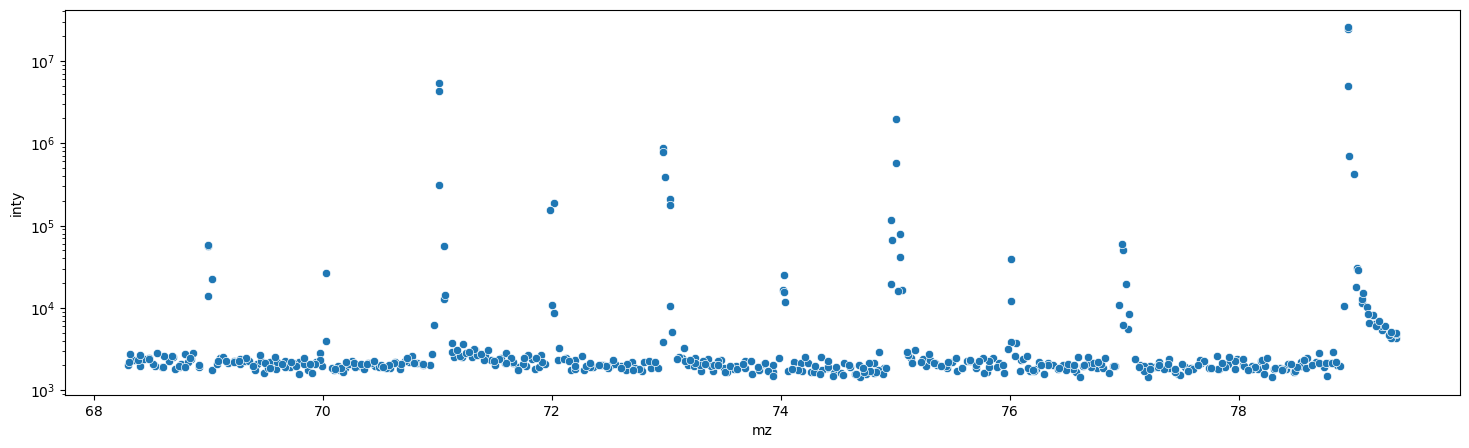

In [15]:
clustered_df = comb_df["clustered_experiment"][0].get_df(long=True)
sns_plot(clustered_df["mz"], clustered_df["inty"], xlim=None, ylim=None,plottype="scatter", log=["y"], sizes=(5, 5))   # distinct: tab10, continous: hls

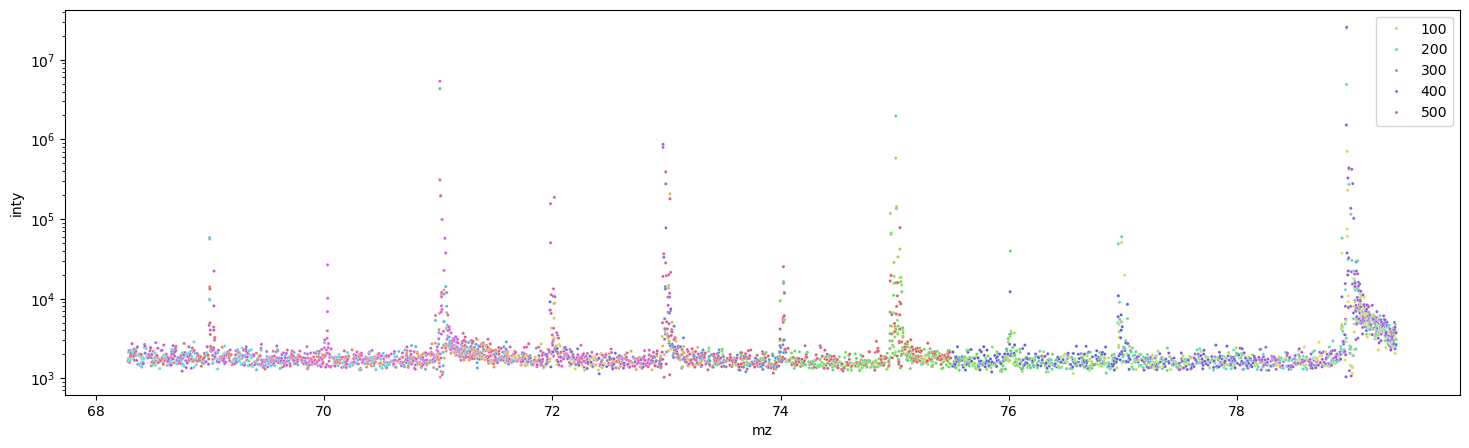

In [ ]:
sns_plot(peaked_df["mz"][llim:ulim], peaked_df["inty"][llim:ulim], hue=clustering, size=clustering,
         xlim=None, ylim=None,plottype="scatter", log=["y"], sizes=(5, 5), palette="hls")   # distinct: tab10, continous: hls